In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib widget

import importlib
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [2]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [3]:
import ast
import re

def fix_number_format(value):
    if isinstance(value, str):
        # Add a comma after an integer followed by a float
        value = re.sub(r'(\d+)\.\s+(\d)', r'\1., \2', value)
        
        # Add commas between numbers wherever necessary
        value = re.sub(r'(?<=\d)\s+(?=[\d\.])', ', ', value)
    return value

def convert_to_list(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except Exception as e:
            print(f"Error converting value: {value}, error: {e}")
            return value
    return value

# Apply this function to the relevant columns
columns_to_convert = ['F_max', 'F_stat', 'phi_stat', 'NPQ', 'ETR']


In [67]:
PSI_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI"

strain_to_color = {
    "Pt1-1": "C0",
    "Pt1-3": "C1",
    "Pt1-26": "C2",
    "Pt1-27": "C3",
    "Pt1-11": "C4",
    "Pt1-43": "C5",
    "Pt2": "C0",
    "KO6": "C1",
    "LtpM": "C2"
}


# get all folders in the PSI folder
experiments = [f for f in os.listdir(PSI_folder) if os.path.isdir(os.path.join(PSI_folder, f))]

# strains = ["Pt1-1", "Pt1-3", "Pt1-26", "Pt1-27", "Pt1-11", "Pt1-43"]
# strains = ["Pt1-1", "Pt1-3", "Pt1-26", "Pt1-27", "Pt1-11", "Pt1-43"]

strains = ["Pt2", "KO6", "LtpM"]
replicates = []

for strain in strains:
    pattern = re.compile(rf"activation_{strain}(?!\d)")
    replicates.append([experiment for experiment in experiments if pattern.search(experiment)])

In [68]:
results = []
for i, strain in enumerate(strains):
    results.append([])
    for replicate in replicates[i]:
        path = f"{PSI_folder}/{replicate}/params.csv"
        df = pd.read_csv(path, index_col= False, sep=";")
        for column in columns_to_convert:
            df[column] = df[column].apply(fix_number_format)
            df[column] = df[column].apply(convert_to_list)
        results[i].append(df)
        

In [69]:
replicates

[['20241014_activation_Pt2',
  '20241025_activation_Pt2_afternoon_bicarbonate',
  '20241025_activation_Pt2_afternoon_control',
  '20241027_activation_Pt2_morning_bicarbonate',
  '20241027_activation_Pt2_morning_control',
  '20241106_activation_Pt2'],
 ['20241015_activation_KO6', '20241106_activation_KO6'],
 ['20241021_activation_LtpM']]

Text(0.5, 1.0, 'P x I curve')

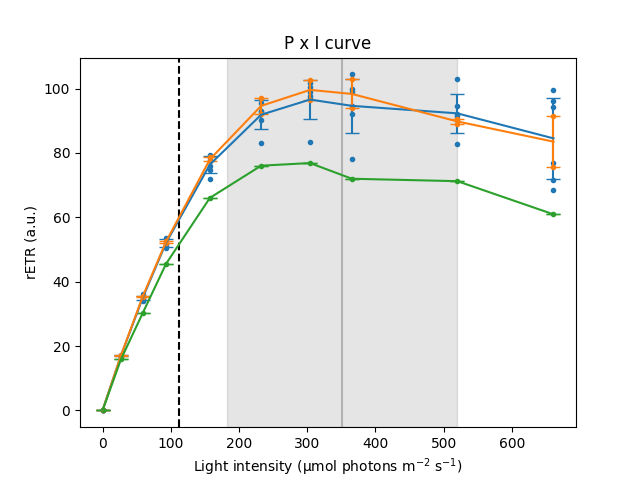

In [72]:
Ek_offset = 3.13
Ek_amp = 1.5


fig, ax = plt.subplots()
ETR = []
for i, strain in enumerate(strains):
    ETR.append([])
    for j, replicate in enumerate(replicates[i]):
        ETR[i].append([ETR_aux[-1] for ETR_aux in results[i][j]['ETR']])
        ax.plot(results[i][j]['Actinic'], ETR[i][-1], 'o', color = strain_to_color[strain], markersize = 3)
    ETR[i] = np.array(ETR[i])
    ax.errorbar(results[i][j]['Actinic'], np.mean(ETR[i], axis = 0), yerr = np.std(ETR[i], axis = 0), fmt = '-', color = strain_to_color[strain], label = f"{strain}, n = {len(replicates[i])}", capsize=5)

all_data_array = np.array([replicate for condition in ETR for replicate in condition])
average = np.mean(all_data_array, axis = 0)
popt, pcov, xfit, yfit = tools.Ek_fit(results[i][j]['Actinic'][:7], average[:7], 0, 700, 100, p0=[100, 100])
# ax.plot(xfit, yfit, '--', color="k", linewidth=1)
ylim = ax.get_ylim()
Ek = popt[0]
ax.axvline(Ek, color = "k", linestyle = "--")
ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.5)
ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
ax.set_ylim(ylim)


ax.set_xlabel("Light intensity (µmol photons m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("rETR (a.u.)")
ax.set_title("P x I curve")
# ax.legend()

Text(0.5, 1.0, 'NPQ x I curve')

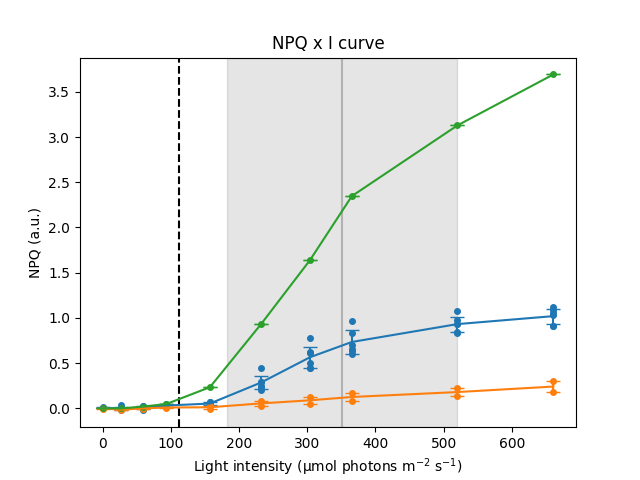

In [73]:
fig, ax = plt.subplots()
NPQ = []
for i, strain in enumerate(strains):
    NPQ.append([])
    for j, replicate in enumerate(replicates[i]):
        NPQ[i].append([NPQ_aux[-1] for NPQ_aux in results[i][j]['NPQ']])
        ax.plot(results[i][j]['Actinic'], NPQ[i][-1], 'o', color = strain_to_color[strain], markersize = 4)
    NPQ[i] = np.array(NPQ[i])
    ax.errorbar(results[i][j]['Actinic'], np.mean(NPQ[i], axis = 0), yerr = np.std(NPQ[i], axis = 0), fmt = '-', color = strain_to_color[strain], label = f"{strain} mean, n = {len(replicates[i])}", capsize=5)
ylim = ax.get_ylim()
ax.axvline(Ek, color = "k", linestyle = "--")
ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.5)
ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
ax.set_ylim(ylim)

ax.set_xlabel("Light intensity (µmol photons m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("NPQ (a.u.)")
ax.set_title("NPQ x I curve")
# ax.legend()

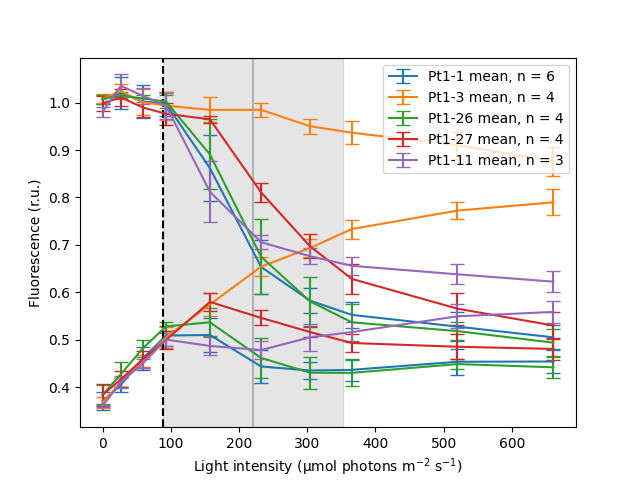

In [44]:
fig, ax = plt.subplots()
F_stat = []
F_max = []
for i, strain in enumerate(strains):
    F_stat.append([])
    F_max.append([])
    for j, replicate in enumerate(replicates[i]):
        F_stat[i].append([F_stat_aux[-1] for F_stat_aux in results[i][j]['F_stat']])
        F_max[i].append([F_max_aux[-1] for F_max_aux in results[i][j]['F_max']])
        # ax.plot(results[i][j]['Actinic'], F_stat[i][-1], 'o', color = f"C{i}", markersize = 3, alpha = 0.2)
        # ax.plot(results[i][j]['Actinic'], F_max[i][-1], 'o', color = f"C{i}", markersize = 3, alpha = 0.2)
    F_stat[i] = np.array(F_stat[i])
    F_max[i] = np.array(F_max[i])
    ax.errorbar(results[i][j]['Actinic'], np.mean(F_stat[i], axis = 0), yerr = np.std(F_stat[i], axis = 0), fmt = '-', color = f"C{i}", label = f"{strain} mean, n = {len(replicates[i])}", capsize=5)
    ax.errorbar(results[i][j]['Actinic'], np.mean(F_max[i], axis = 0), yerr = np.std(F_max[i], axis = 0), fmt = '-', color = f"C{i}", capsize=5)

ylim = ax.get_ylim()
ax.axvline(Ek, color = "k", linestyle = "--")
ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.5)
ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
ax.set_ylim(ylim)

ax.set_xlabel("Light intensity (µmol photons m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("Fluorescence (r.u.)")
ax.legend()

(-0.1, 0.4)

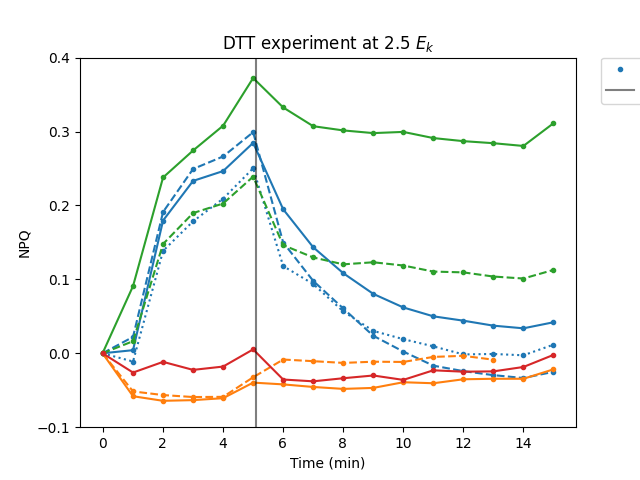

In [ ]:
marker = 3
alpha = 0.7

strains = [1, 3, 26, 27]
fmts = ["-o", "--o", ":o"]
labels = []

fig, ax = plt.subplots()
for i, strain in enumerate(strains):
    names = exp_list[exp_list["Strain"] == strain]["Name"].to_list()
    for j, name in enumerate(names):
        i_list = exp_list[exp_list["Name"] == name].index.values[0]
        path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI/" + name + "/params.csv"
        params = pd.read_csv(path, index_col= False, sep=";")
        time = (params["Time"].to_numpy() - params["Time"].to_numpy()[0])/60
        NPQ = params["NPQ"].to_numpy()
        ax.plot(time, NPQ, fmts[j], color = f"C{i}", markersize = marker)

ax.plot([], [], "o", color = "C0", markersize = marker, label = "WT")
ax.axvline(x= 5.1, color = 'k', linestyle = '-', label = 'DTT added', alpha = 0.5) 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel("Time (min)")
ax.set_ylabel("NPQ")
ax.set_title("DTT experiment at 2.5 $E_k$")
ax.set_ylim(-0.1, 0.4)


(-0.1, 0.4)

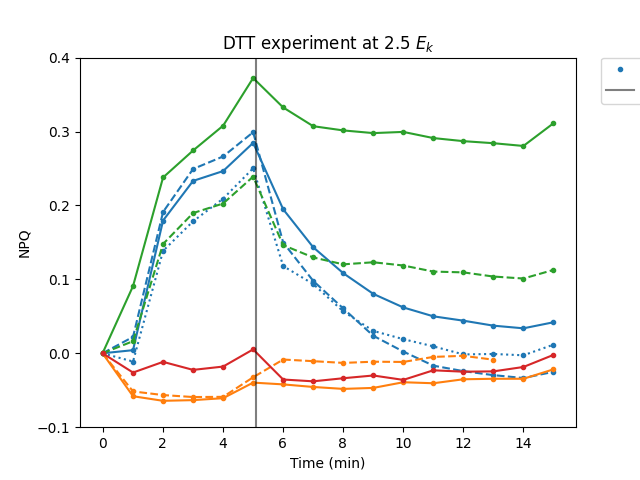

In [ ]:
marker = 3
alpha = 0.7

strains = [1, 3, 26, 27]
fmts = ["-o", "--o", ":o"]
labels = []

fig, ax = plt.subplots()
for i, strain in enumerate(strains):
    names = exp_list[exp_list["Strain"] == strain]["Name"].to_list()
    for j, name in enumerate(names):
        i_list = exp_list[exp_list["Name"] == name].index.values[0]
        path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI/" + name + "/params.csv"
        params = pd.read_csv(path, index_col= False, sep=";")
        time = (params["Time"].to_numpy() - params["Time"].to_numpy()[0])/60
        NPQ = params["NPQ"].to_numpy()
        ax.plot(time, NPQ, fmts[j], color = f"C{i}", markersize = marker)

ax.plot([], [], "o", color = "C0", markersize = marker, label = "WT")
ax.axvline(x= 5.1, color = 'k', linestyle = '-', label = 'DTT added', alpha = 0.5) 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel("Time (min)")
ax.set_ylabel("NPQ")
ax.set_title("DTT experiment at 2.5 $E_k$")
ax.set_ylim(-0.1, 0.4)


(-0.1, 0.4)

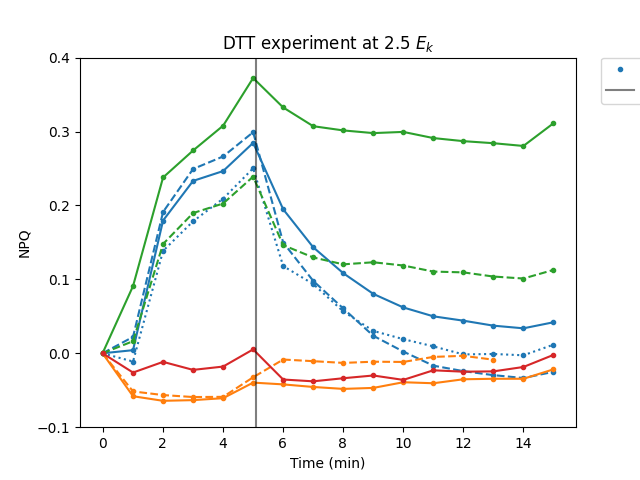

In [ ]:
marker = 3
alpha = 0.7

strains = [1, 3, 26, 27]
fmts = ["-o", "--o", ":o"]
labels = []

fig, ax = plt.subplots()
for i, strain in enumerate(strains):
    names = exp_list[exp_list["Strain"] == strain]["Name"].to_list()
    for j, name in enumerate(names):
        i_list = exp_list[exp_list["Name"] == name].index.values[0]
        path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI/" + name + "/params.csv"
        params = pd.read_csv(path, index_col= False, sep=";")
        time = (params["Time"].to_numpy() - params["Time"].to_numpy()[0])/60
        NPQ = params["NPQ"].to_numpy()
        ax.plot(time, NPQ, fmts[j], color = f"C{i}", markersize = marker)

ax.plot([], [], "o", color = "C0", markersize = marker, label = "WT")
ax.axvline(x= 5.1, color = 'k', linestyle = '-', label = 'DTT added', alpha = 0.5) 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel("Time (min)")
ax.set_ylabel("NPQ")
ax.set_title("DTT experiment at 2.5 $E_k$")
ax.set_ylim(-0.1, 0.4)


(-0.1, 0.4)

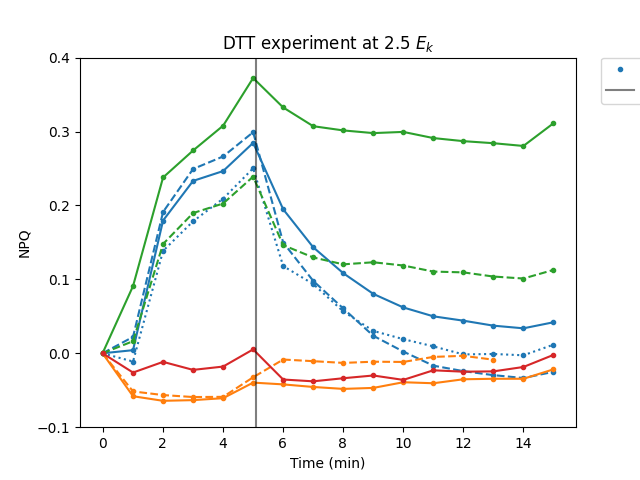

In [ ]:
marker = 3
alpha = 0.7

strains = [1, 3, 26, 27]
fmts = ["-o", "--o", ":o"]
labels = []

fig, ax = plt.subplots()
for i, strain in enumerate(strains):
    names = exp_list[exp_list["Strain"] == strain]["Name"].to_list()
    for j, name in enumerate(names):
        i_list = exp_list[exp_list["Name"] == name].index.values[0]
        path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI/" + name + "/params.csv"
        params = pd.read_csv(path, index_col= False, sep=";")
        time = (params["Time"].to_numpy() - params["Time"].to_numpy()[0])/60
        NPQ = params["NPQ"].to_numpy()
        ax.plot(time, NPQ, fmts[j], color = f"C{i}", markersize = marker)

ax.plot([], [], "o", color = "C0", markersize = marker, label = "WT")
ax.axvline(x= 5.1, color = 'k', linestyle = '-', label = 'DTT added', alpha = 0.5) 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel("Time (min)")
ax.set_ylabel("NPQ")
ax.set_title("DTT experiment at 2.5 $E_k$")
ax.set_ylim(-0.1, 0.4)


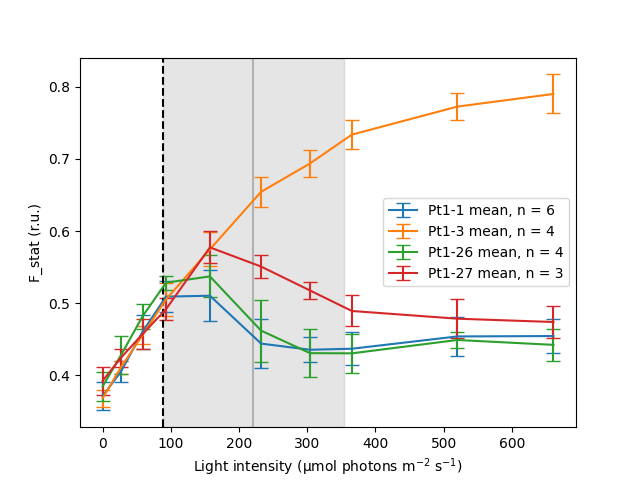

In [168]:


fig, ax = plt.subplots()
F_stat = []
for i, strain in enumerate(strains):
    F_stat.append([])
    for j, replicate in enumerate(replicates[i]):
        F_stat[i].append([F_stat_aux[-1] for F_stat_aux in results[i][j]['F_stat']])
        # ax.plot(results[i][j]['Actinic'], F_stat[i][-1], 'o', color = f"C{i}", markersize = 3, alpha = 0.2)
    F_stat[i] = np.array(F_stat[i])
    ax.errorbar(results[i][j]['Actinic'], np.mean(F_stat[i], axis = 0), yerr = np.std(F_stat[i], axis = 0), fmt = '-', color = f"C{i}", label = f"{strain} mean, n = {len(replicates[i])}", capsize=5)

ylim = ax.get_ylim()
ax.axvline(Ek, color = "k", linestyle = "--")
ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.5)
ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
ax.set_ylim(ylim)

ax.set_xlabel("Light intensity (µmol photons m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("F_stat (r.u.)")
ax.legend()